<a href="https://colab.research.google.com/github/doesip2020s/aaa/blob/main/MIMIC_Self_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title MIMIC-III Tutorial: Patient Clustering with K-Means

In [ ]:
# 0) Setup
!pip install -q pandas numpy scikit-learn matplotlib tqdm

import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

pd.set_option('display.max_columns', 100)

In [ ]:
# Mount Google Drive
USE_GOOGLE_DRIVE = True  # set False if using direct upload
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# @title 1) Load data
PATH_PATIENTS   = "/content/drive/MyDrive/PATIENTS.csv"
PATH_ADMISSIONS = "/content/drive/MyDrive/ADMISSIONS.csv"
patients = pd.read_csv(PATH_PATIENTS,
                         usecols=["SUBJECT_ID","GENDER","DOB","DOD"])
admissions = pd.read_csv(PATH_ADMISSIONS,
                         usecols=["SUBJECT_ID","HADM_ID","ADMITTIME",
                                  "DISCHTIME","ADMISSION_TYPE","ADMISSION_LOCATION",
                                  "DISCHARGE_LOCATION","INSURANCE",
                                  "LANGUAGE","RELIGION","MARITAL_STATUS","ETHNICITY"
])

In [ ]:
# @title 2) Basic cleaning + feature engineering
# Ensure admissions dataframe is in a state before the problematic merge
# Reload or recreate the admissions dataframe if necessary, or carefully drop potential duplicate columns
# Assuming the last successful state was before the problematic merge, we can proceed

# Rename DOB and DOD columns in patients before merging
patients_renamed = patients[["SUBJECT_ID", "DOB", "GENDER", "DOD"]].rename(columns={"DOB": "DOB_patient", "DOD": "DOD_patient", "GENDER": "GENDER_patient"})

# Merge the admissions DataFrame with the renamed patients DataFrame
# Explicitly set suffixes to avoid conflicts if columns like 'DOB' or 'GENDER' already exist in admissions
# We want the columns from patients_renamed to keep their new names ('DOB_patient', 'DOD_patient', 'GENDER_patient')
# and any original conflicting columns in admissions to get a suffix, e.g., '_orig'
admissions = admissions.merge(patients_renamed, on="SUBJECT_ID", how="left", suffixes=('', '_from_patients'))

# Note: After this merge, columns from admissions will have no suffix, and columns from patients_renamed will have '_from_patients' IF there was a name conflict.
# Since we renamed in patients_renamed, there *shouldn't* be a conflict with original admissions columns like 'DOB' or 'DOD'.
# Let's check the columns again after this merge to be sure.

# Print columns after merge to debug
print("Columns after merge:", admissions.columns)

Columns after merge: Index(['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME', 'ADMISSION_TYPE',
       'ADMISSION_LOCATION', 'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE',
       'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'DOB_patient',
       'GENDER_patient', 'DOD_patient'],
      dtype='object')


In [ ]:
# Convert the new patient DOB and DOD columns to datetime and original admission/discharge times
# Use the correct column names based on the merge result (should be DOB_patient, DOD_patient, GENDER_patient)
admissions["ADMITTIME"] = pd.to_datetime(admissions["ADMITTIME"], errors="coerce")
admissions["DISCHTIME"] = pd.to_datetime(admissions["DISCHTIME"], errors="coerce")
admissions["DOB_patient"] = pd.to_datetime(admissions["DOB_patient"], errors="coerce")
admissions["DOD_patient"] = pd.to_datetime(admissions["DOD_patient"], errors="coerce")

# Drop the original 'DOB' and 'DOD' columns from the merged dataframe if they still exist
# Based on previous attempts and the error, columns like 'DOB_x' or 'DOB_y' might exist.
# Let's drop potential problematic columns from previous failed merges explicitly.
admissions = admissions.drop(columns=['DOB', 'DOD', 'DOB_x', 'DOB_y', 'GENDER_x', 'GENDER_y', 'DOD_x', 'DOD_y'], errors='ignore')

# Filter out rows with missing ADMITTIME or DOB_patient
admissions = admissions[(admissions["ADMITTIME"].notna()) & (admissions["DOB_patient"].notna())].copy()

# Compute age at admission using Unix timestamps to avoid overflow
# Convert datetime to Unix timestamp (seconds since epoch)
admissions["admittime_ts"] = admissions["ADMITTIME"].astype(np.int64) // 10**9
admissions["dob_ts"] = admissions["DOB_patient"].astype(np.int64) // 10**9

# Calculate age in years using the difference in timestamps
admissions["age"] = (admissions["admittime_ts"] - admissions["dob_ts"]) / (365.25 * 24 * 3600)

# Drop the intermediate timestamp columns
admissions = admissions.drop(columns=['admittime_ts', 'dob_ts'])

# Handle negative ages and clamp outliers as per MIMIC-III specifications
admissions.loc[admissions["age"] < 0, "age"] = np.nan # Handle cases where admit time is before DOB
admissions.loc[admissions["age"] > 120, "age"] = np.nan  # drop wild outliers if any
admissions["age"] = admissions["age"].clip(lower=0, upper=90)

# Calculate length of stay in days
admissions["los_days"] = (admissions["DISCHTIME"] - admissions["ADMITTIME"]).dt.total_seconds() / (3600*24)

In [ ]:
# Keep reasonable stays (remove obvious data errors)
# Ensure los_days is calculated or exists from previous steps.
# Assuming los_days was calculated earlier, we apply the filter.
# If not, it needs to be calculated here: admissions["los_days"] = (admissions["DISCHTIME"] - admissions["ADMITTIME"]).dt.total_seconds() / (3600*24)
# Based on the history, los_days was calculated before the merge issues.
admissions = admissions[(admissions["los_days"]>=0) & (admissions["los_days"]<=60)].copy()

# Mortality flag at the stay-level (did the patient die before or on discharge?)
admissions["expired"] = (admissions["DOD_patient"].notna()) & (admissions["DOD_patient"] <= admissions["DISCHTIME"])

# Select a compact feature set (easy to explain)
feat_cols_num = ["age","los_days"]
feat_cols_cat = ["ADMISSION_TYPE","INSURANCE","ETHNICITY"]

# Drop rows with missing core numeric features
admissions_clean = admissions.dropna(subset=feat_cols_num).copy()

In [ ]:
# @title 2.1 One hot coding
# Define the top_k_one_hot function
def top_k_one_hot(df, col, k=8):
    top = df[col].value_counts().nlargest(k).index
    # Ensure the column exists before trying to fillna or apply isin
    if col not in df.columns:
        print(f"Warning: Column '{col}' not found in dataframe for one-hot encoding.")
        return pd.DataFrame() # Return empty dataframe if column is missing

    df[col] = np.where(df[col].isin(top), df[col], "OTHER")
    return pd.get_dummies(df[col], prefix=col, drop_first=False)


# Apply the top_k_one_hot function
onehots = []
for c in feat_cols_cat:
    # Operate on admissions_clean as missing values were dropped
    onehots.append(top_k_one_hot(admissions_clean.copy(), c, k=8)) # Use a copy to avoid modifying admissions_clean in place during iteration

# Concatenate one-hot encoded dataframes, handling cases where a column might have been missing
if onehots:
    X_cat = pd.concat(onehots, axis=1)
else:
    X_cat = pd.DataFrame() # Handle case where no categorical columns were processed


# Create the y_info dataframe
# Use the suffixed GENDER column from patients (GENDER_patient)
# Also include the original categorical columns from admissions_clean for y_info
y_info = admissions_clean[["SUBJECT_ID","HADM_ID","GENDER_patient","expired"] + feat_cols_cat].reset_index(drop=True)


# Concatenate the numeric features from admissions_clean and the one-hot encoded categorical features X_cat
# Ensure columns exist before concatenating
numeric_features = admissions_clean[feat_cols_num].reset_index(drop=True)

if not X_cat.empty:
    X = pd.concat([numeric_features, X_cat.reset_index(drop=True)], axis=1)
else:
    X = numeric_features # If no categorical features were encoded


# Print the shape of the final feature matrix X
print("Feature matrix shape:", X.shape)

# Display the first few rows of X and y_info to verify
print("\nFeature matrix X head:")
display(X.head())

print("\ny_info head:")
display(y_info.head())

Feature matrix shape: (55595, 19)

Feature matrix X head:


,age,los_days,ADMISSION_TYPE_ELECTIVE,ADMISSION_TYPE_EMERGENCY,ADMISSION_TYPE_NEWBORN,ADMISSION_TYPE_URGENT,INSURANCE_Government,INSURANCE_Medicaid,INSURANCE_Medicare,INSURANCE_Private,INSURANCE_Self Pay,ETHNICITY_ASIAN,ETHNICITY_BLACK/AFRICAN AMERICAN,ETHNICITY_HISPANIC OR LATINO,ETHNICITY_OTHER,ETHNICITY_PATIENT DECLINED TO ANSWER,ETHNICITY_UNABLE TO OBTAIN,ETHNICITY_UNKNOWN/NOT SPECIFIED,ETHNICITY_WHITE
0,64.926812,1.144444,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True
1,71.130191,5.496528,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True
2,75.254799,6.768056,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True
3,39.016226,2.856944,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True
4,58.948905,3.534028,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True



y_info head:


,SUBJECT_ID,HADM_ID,GENDER_patient,expired,ADMISSION_TYPE,INSURANCE,ETHNICITY
0,22,165315,F,False,EMERGENCY,Private,WHITE
1,23,152223,M,False,ELECTIVE,Medicare,WHITE
2,23,124321,M,False,EMERGENCY,Medicare,WHITE
3,24,161859,M,False,EMERGENCY,Private,WHITE
4,25,129635,M,False,EMERGENCY,Private,WHITE


In [ ]:
# Select a compact feature set (easy to explain)
feat_cols_num = ["age","los_days"]
feat_cols_cat = ["ADMISSION_TYPE","INSURANCE","ETHNICITY"]

# Drop rows with missing core numeric features
admissions_clean = admissions.dropna(subset=feat_cols_num).copy()

# One-hot encode selected categorical columns (keep top categories to avoid explosion)
def top_k_one_hot(df, col, k=8):
    top = df[col].value_counts().nlargest(k).index
    df[col] = np.where(df[col].isin(top), df[col], "OTHER")
    return pd.get_dummies(df[col], prefix=col, drop_first=False)

onehots = []
for c in feat_cols_cat:
    onehots.append(top_k_one_hot(admissions_clean.copy(), c, k=8))

X_cat = pd.concat(onehots, axis=1)

X = pd.concat([admissions_clean[feat_cols_num].reset_index(drop=True), X_cat.reset_index(drop=True)], axis=1)
y_info = admissions_clean[["SUBJECT_ID","HADM_ID","GENDER_patient","expired","ADMISSION_TYPE","INSURANCE","ETHNICITY"]].reset_index(drop=True)

print("Feature matrix shape:", X.shape)

Feature matrix shape: (55595, 19)


In [ ]:
# Concatenate the numeric features from admissions_clean and the one-hot encoded categorical features X_cat
# Ensure columns exist before concatenating
numeric_features = admissions_clean[feat_cols_num].reset_index(drop=True)

if not X_cat.empty:
    X = pd.concat([numeric_features, X_cat.reset_index(drop=True)], axis=1)
else:
    X = numeric_features # If no categorical features were encoded

# Create the y_info dataframe
# Use the suffixed GENDER column from patients (GENDER_patient)
# Also include the original categorical columns from admissions_clean for y_info
y_info = admissions_clean[["SUBJECT_ID","HADM_ID","GENDER_patient","expired"] + feat_cols_cat].reset_index(drop=True)


# Print the shape of the final feature matrix X
print("Feature matrix shape:", X.shape)

Feature matrix shape: (55595, 19)


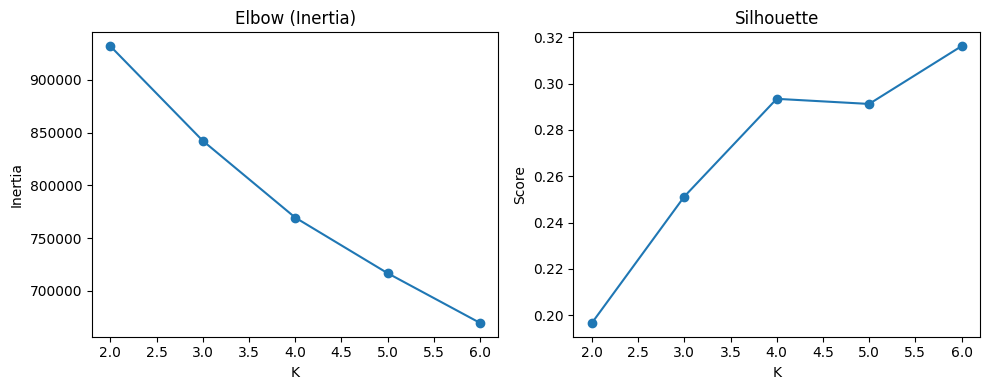

Chosen K = 6 | silhouette = 0.316


In [ ]:
# @title 3) Scale, pick K, fit K-Means

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Quick elbow + silhouette to choose K (small range, to keep it fast)
Ks = [2,3,4,5,6]
inertias = []
sils = []
for k in Ks:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    sils.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.plot(Ks, inertias, marker="o"); plt.title("Elbow (Inertia)"); plt.xlabel("K"); plt.ylabel("Inertia")
plt.subplot(1,2,2); plt.plot(Ks, sils, marker="o"); plt.title("Silhouette"); plt.xlabel("K"); plt.ylabel("Score")
plt.tight_layout(); plt.show()

# Choose K (simple heuristic: best silhouette; if tie, smaller K)
best_idx = int(np.argmax(sils))
best_k = Ks[best_idx]
print("Chosen K =", best_k, "| silhouette =", round(sils[best_idx], 3))

kmeans = KMeans(n_clusters=best_k, n_init=25, random_state=42)
labels = kmeans.fit_predict(X_scaled)

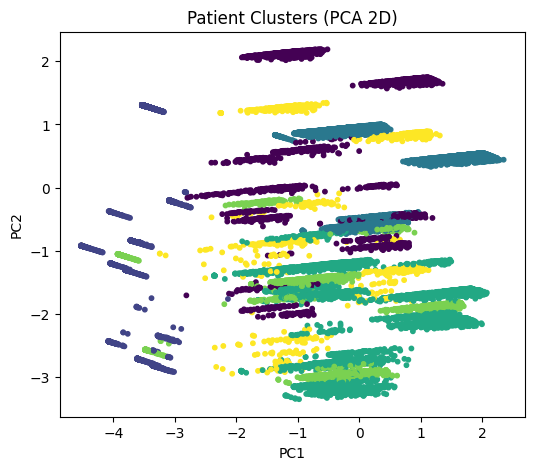

In [ ]:
# @title 4) Visualize clusters with PCA(2)

pca = PCA(n_components=2, random_state=42)
Z = pca.fit_transform(X_scaled)

plt.figure(figsize=(6,5))
scatter = plt.scatter(Z[:,0], Z[:,1], c=labels, s=10)
plt.title("Patient Clusters (PCA 2D)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()

In [ ]:
# @title 5) Cluster summaries for your slides

out = pd.concat([y_info, pd.DataFrame(X, columns=X.columns)], axis=1)
out["cluster"] = labels

summary_num = out.groupby("cluster")[["age","los_days"]].agg(["mean","median","std","count"])
summary_cat = out.groupby("cluster")[["expired","ADMISSION_TYPE","INSURANCE","ETHNICITY"]].agg(
    {"expired":"mean","ADMISSION_TYPE":lambda s: s.value_counts().head(3).to_dict(),
     "INSURANCE":lambda s: s.value_counts().head(3).to_dict(),
     "ETHNICITY":lambda s: s.value_counts().head(3).to_dict()}
)
print("Numeric feature summary by cluster:")
display(summary_num)
print("\nCategorical snapshot by cluster (top-3 counts):")
display(summary_cat)

# Helpful compact view for slides
compact = out.groupby("cluster").agg(
    n=("cluster","size"),
    age_mean=("age","mean"),
    los_mean=("los_days","mean"),
    expired_rate=("expired","mean")
).round({"age_mean":1, "los_mean":2, "expired_rate":3})
display(compact)

Numeric feature summary by cluster:


age                                los_days            \
              mean     median        std  count       mean    median   
cluster                                                                
0        63.347088  64.581294  13.711913   7112   8.398097  6.320486   
1         0.001957   0.001489   0.011410   7013   8.172687  4.036111   
2        63.394859  65.615108  17.093299  27323   9.790836  6.979861   
3        59.135933  61.207078  18.420882   9625   9.351106  6.704167   
4        48.959451  55.654090  27.063509   3245   9.244540  6.125000   
5        61.841485  64.525183  17.557537   1277  11.532864  8.104861   

                           
               std  count  
cluster                    
0         7.104860   7112  
1        10.796345   7013  
2         9.003899  27323  
3         8.746767   9625  
4         9.213056   3245  
5        10.111502   1277


Categorical snapshot by cluster (top-3 counts):


,expired,ADMISSION_TYPE,INSURANCE,ETHNICITY
cluster,,,,
0,0.024466,{'ELECTIVE': 7112},"{'Medicare': 3582, 'Private': 3073, 'Medicaid'...","{'WHITE': 5786, 'UNKNOWN/NOT SPECIFIED': 512, ..."
1,0.007130,{'NEWBORN': 7013},"{'Private': 5622, 'Medicaid': 1014, 'Governmen...","{'WHITE': 4577, 'BLACK/AFRICAN AMERICAN': 822,..."
2,0.121546,{'EMERGENCY': 27323},"{'Medicare': 15324, 'Private': 9143, 'Medicaid...",{'WHITE': 27323}
3,0.131948,{'EMERGENCY': 9625},"{'Medicare': 4864, 'Private': 2625, 'Medicaid'...","{'BLACK/AFRICAN AMERICAN': 4024, 'UNKNOWN/NOT ..."
4,0.070570,"{'EMERGENCY': 2293, 'NEWBORN': 516, 'ELECTIVE'...","{'Private': 1164, 'Medicare': 1095, 'Medicaid'...","{'OTHER': 1421, 'ASIAN - CHINESE': 261, 'HISPA..."
5,0.118246,{'URGENT': 1277},"{'Medicare': 653, 'Private': 475, 'Medicaid': ...","{'WHITE': 671, 'UNKNOWN/NOT SPECIFIED': 433, '..."


,n,age_mean,los_mean,expired_rate
cluster,,,,
0,7112,63.3,8.40,0.024
1,7013,0.0,8.17,0.007
2,27323,63.4,9.79,0.122
3,9625,59.1,9.35,0.132
4,3245,49.0,9.24,0.071
5,1277,61.8,11.53,0.118
